# Intro

The purpose of this notebook is to cover some of the mass budgeting which is done by An in the recent file. Ie this is to explain the forcing of air on the ocean, ice on the surface ocean, etc in TS space.

# Import packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh
from plotting_helpers import *           # truncate_colormap

In [2]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [4]:
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
mask = (mymsk < 5) | (mymsk==6)

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


['CanadaB' 'ChukchiS' 'MakarovB' 'AmundsenB' 'NansenB' 'BeringS'
 'BarentsS']


(400.0, 860.0)

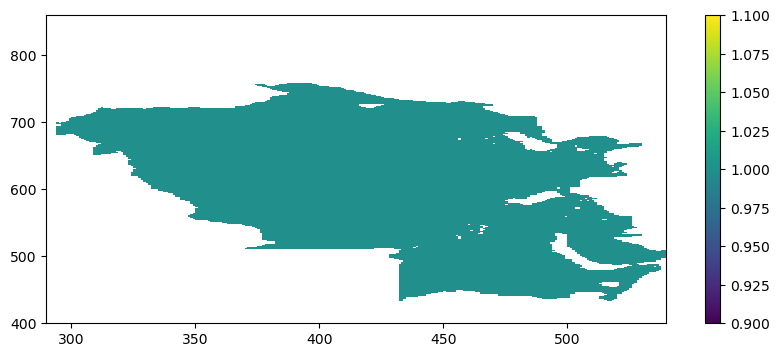

In [5]:
print(strb[0:7])
# plt.pcolormesh(get_aste_tracer(mskBasin,nfx,nfy)[0] * get_aste_tracer(mymsk,nfx,nfy)[0])
plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0])
maskArc = mskBasin * mymsk
plt.colorbar()
plt.xlim(290,540)
plt.ylim(400,860)

# Import the data

In [6]:
'''
263 %tmp=(SIatmFW-oceFWflx-SIsnPrcp).*RAC;   %F(A->I)+F(A->O)-F(I->O)-F(A->O)-F(A->I) = -F(I->O)
264 %budgO.fluxes.ice2ocean=-tmp;            %2d, kg/s, vol flux ice to ocean, note minus sign
265 %tmp=(SIatmFW-SIsnPrcp).*RAC;            %F(A->I) + F(A->O) - F(A->I) = F(A->O)
266 %budgO.fluxes.atm2ocean=tmp;             %2d, kg/s , should be equal to sum(budgO.fluxes.zconv,2)-budgO.fluxes.ice2ocean;
267 %%confirm: sum(sum(ckO.zconv,2)-(ckO.atm2ocean+ckO.ice2ocean)) = -1.6e-9, yes!
268 
269 %clear WVELMASS SIatmFW oceFWflx
270 %clear trWtop trWbot
'''

'\n263 %tmp=(SIatmFW-oceFWflx-SIsnPrcp).*RAC;   %F(A->I)+F(A->O)-F(I->O)-F(A->O)-F(A->I) = -F(I->O)\n264 %budgO.fluxes.ice2ocean=-tmp;            %2d, kg/s, vol flux ice to ocean, note minus sign\n265 %tmp=(SIatmFW-SIsnPrcp).*RAC;            %F(A->I) + F(A->O) - F(A->I) = F(A->O)\n266 %budgO.fluxes.atm2ocean=tmp;             %2d, kg/s , should be equal to sum(budgO.fluxes.zconv,2)-budgO.fluxes.ice2ocean;\n267 %%confirm: sum(sum(ckO.zconv,2)-(ckO.atm2ocean+ckO.ice2ocean)) = -1.6e-9, yes!\n268 \n269 %clear WVELMASS SIatmFW oceFWflx\n270 %clear trWtop trWbot\n'

In [7]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
# times["2014"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
times["2014"] = np.array([3,9])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

In [8]:
file_name = 'budg3d_snap_set2'
THETADR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["THETADR"]),mymsk,dirIn)
SALTDR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["SALTDR"]),mymsk,dirIn)

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

In [9]:
# budg2d_zflux_set1: SIatmFW, oceFWflx
file_name = "budg2d_zflux_set1"
SIatmFW = read_field2d(tsstr,ny,nx,file_name,np.array(['SIatmFW']),mymsk,dirIn)
oceFWflx = read_field2d(tsstr,ny,nx,file_name,np.array(['oceFWflx']),mymsk,dirIn)

In [10]:
# budg2d_zflux_set2: SIsnPrcp
file_name = "budg2d_zflux_set2"
SIsnPrcp = read_field2d(tsstr,ny,nx,file_name,np.array(['SIsnPrcp']),mymsk,dirIn)

In [11]:
# budg2d_snap_set1: SIarea (for percent ocean/ice covered)
file_name = "budg2d_snap_set1"
SIarea = read_field2d(tsstr,ny,nx,file_name,np.array(['SIarea']),mymsk,dirIn)

# Calculate from SIarea the oceFW from A and and I

In [12]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

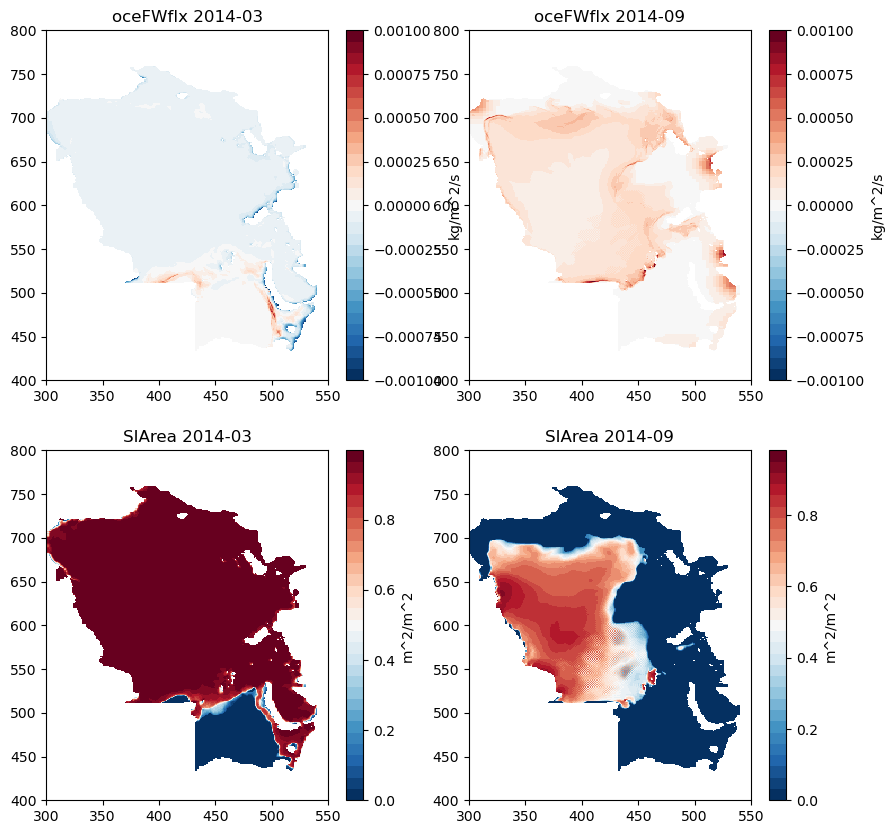

In [13]:
# look at fraction of ice cover from SIarea

fig = plt.figure(figsize=(10,10))

ax = plt.subplot(221)
cb = ax.pcolormesh(get_aste_tracer(oceFWflx[0],nfx,nfy)[0],cmap=cmap,vmin=-0.001,vmax=0.001)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("oceFWflx " + datetimes[0].strftime("%Y-%m"))

ax = plt.subplot(222)
cb = ax.pcolormesh(get_aste_tracer(oceFWflx[1],nfx,nfy)[0],cmap=cmap,vmin=-0.001,vmax=0.001)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("oceFWflx " + datetimes[1].strftime("%Y-%m"))

ax = plt.subplot(223)
cb = ax.pcolormesh(get_aste_tracer(SIarea[0],nfx,nfy)[0],cmap=cmap)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="m^2/m^2")
ax.set_title("SIArea " + datetimes[0].strftime("%Y-%m"))

ax = plt.subplot(224)
cb = ax.pcolormesh(get_aste_tracer(SIarea[1],nfx,nfy)[0],cmap=cmap)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="m^2/m^2")
ax.set_title("SIArea " + datetimes[1].strftime("%Y-%m"))

plt.savefig(path + "ocefWflx_vs_siarea.png",dpi=300)

In [14]:
# create two arrays of shape ny, nx -- one for A to O and one for I to O
# also do for SIatmFW and SIsnPrcp

oceFWflx_AtoO = (1-SIarea) * oceFWflx
oceFWflx_ItoO = SIarea * oceFWflx

SIatmFW_AtoO = (1-SIarea) * SIatmFW
SIatmFW_ItoO = SIarea * SIatmFW

SIsnPrcp_AtoO = (1-SIarea) * SIsnPrcp
SIsnPrcp_ItoO = SIarea * SIsnPrcp

In [16]:
print(np.nanmin(oceFWflx_AtoO[1]),np.nanmax(oceFWflx_AtoO[1]))

-1.1788462594401315e-05 0.0014802045429228594


In [20]:
b = get_aste_tracer(oceFWflx[1],nfy,nfy)[0]
b[475,450]

-2.420023955861619e-06

In [18]:
a = get_aste_tracer(oceFWflx_AtoO[1],nfy,nfy)[0]
a[475,450]

-2.420023955861619e-06

Text(0.5, 1.0, 'oceFWflx ItoO 2014-09')

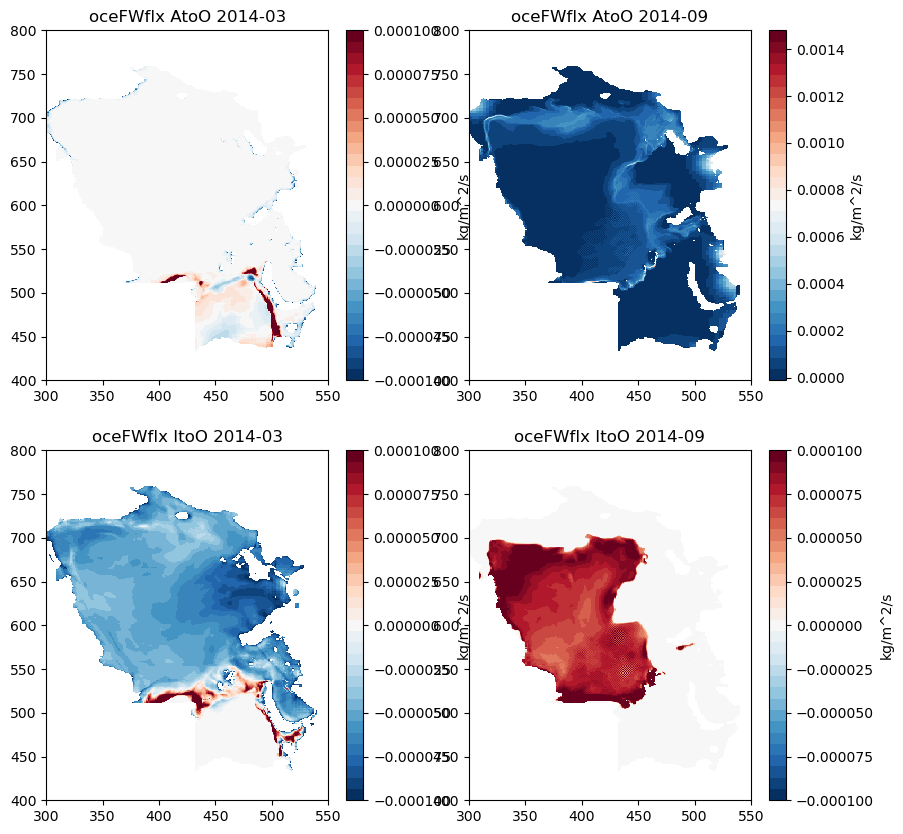

In [15]:
# look at contribution from I to O for the two months and for A to O
fig = plt.figure(figsize=(10,10))

ax = plt.subplot(221)
cb = ax.pcolormesh(get_aste_tracer(oceFWflx_AtoO[0],nfx,nfy)[0],cmap=cmap,vmin=-0.0001,vmax=0.0001)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("oceFWflx AtoO " + datetimes[0].strftime("%Y-%m"))

ax = plt.subplot(222)
cb = ax.pcolormesh(get_aste_tracer(oceFWflx_AtoO[1],nfx,nfy)[0],cmap=cmap)#,vmin=0,vmax=0.001)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("oceFWflx AtoO " + datetimes[1].strftime("%Y-%m"))

ax = plt.subplot(223)
cb = ax.pcolormesh(get_aste_tracer(oceFWflx_ItoO[0],nfx,nfy)[0],cmap=cmap,vmin=-0.0001,vmax=0.0001)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("oceFWflx ItoO " + datetimes[0].strftime("%Y-%m"))

ax = plt.subplot(224)
cb = ax.pcolormesh(get_aste_tracer(oceFWflx_ItoO[1],nfx,nfy)[0],cmap=cmap,vmin=-0.0001,vmax=0.0001)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("oceFWflx ItoO " + datetimes[1].strftime("%Y-%m"))

# plt.savefig(path + "comparable_contributions_ocefwflx.png",dpi=300)

# Do TS binning and plot

In [16]:
# try new T bins where different sizes
refined_section = np.linspace(-3,8,93)
coarse_section = np.linspace(8,15,21,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

In [17]:
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [18]:
# now we can bin the oceFWflx_AtoO and oceFWflx_ItoO based on the TS bins to see where the contribution is
idxs = np.where(~np.isnan(mymsk)) # != np.nan)
npoints = len(idxs[0])

In [19]:
# should be multiplying all by RAC tile

In [20]:
# before we bin we want to multiply by the RAC grid to get rid of area dependency
RAC_tile = np.tile(RAC[np.newaxis,:,:],(len(tsstr),1,1))

oceFWflx_AtoO = oceFWflx_AtoO * RAC_tile   # kg/s
oceFWflx_ItoO = oceFWflx_ItoO * RAC_tile   # kg/s

SIatmFW_AtoO = SIatmFW_AtoO * RAC_tile     # kg/s
SIatmFW_ItoO = SIatmFW_ItoO * RAC_tile     # kg/s

SIsnPrcp_AtoO = SIsnPrcp_AtoO * RAC_tile   # kg/s
SIsnPrcp_ItoO = SIsnPrcp_ItoO * RAC_tile   # kg/s

In [21]:
attr = oceFWflx_AtoO
# only create the mesh with surface theta and salt
mesh_oceFWflx_AtoO = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity[0], binned_theta[0],attr,idxs,dT,dS)   # kg/s/deg C/PSU

attr = oceFWflx_ItoO
mesh_oceFWflx_ItoO = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity[0], binned_theta[0],attr,idxs,dT,dS)   # kg/s/deg C/PSU

In [22]:
# now we can plot these in TS space
AtoO_t1 = np.nansum(mesh_oceFWflx_AtoO[0],axis=2)   # kg/s/degC/PSU
AtoO_t2 = np.nansum(mesh_oceFWflx_AtoO[1],axis=2)   # kg/s/degC/PSU


ItoO_t1 = np.nansum(mesh_oceFWflx_ItoO[0],axis=2)   # kg/s/degC/PSU
ItoO_t2 = np.nansum(mesh_oceFWflx_ItoO[1],axis=2)   # kg/s/degC/PSU

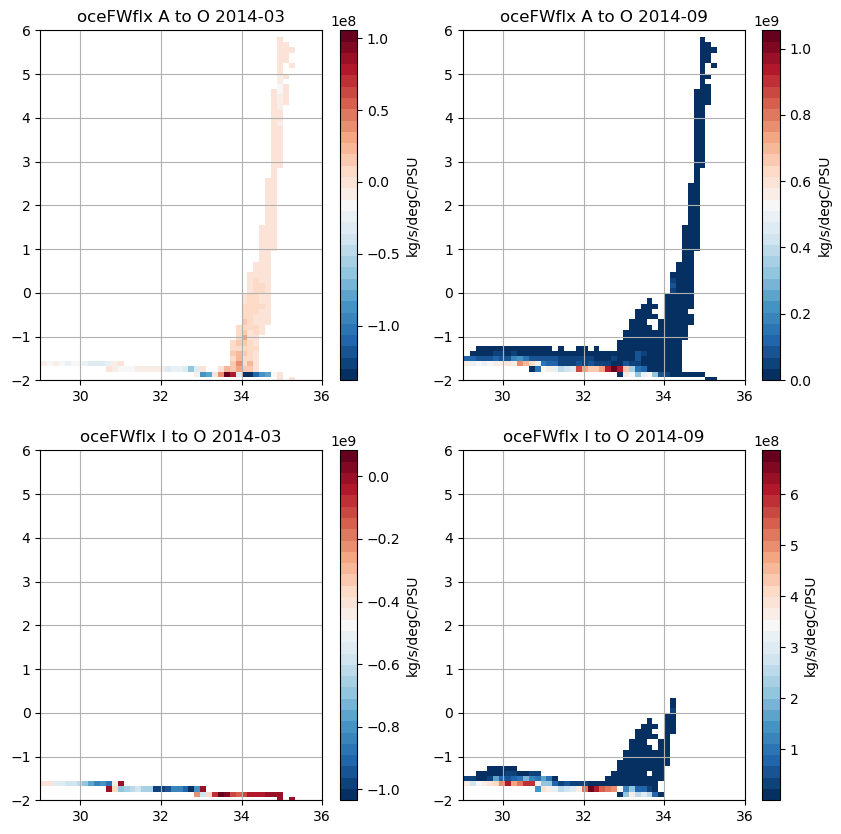

In [23]:
# try to plot an example
fig = plt.figure(figsize=(10,10))

# 
ax1 = plt.subplot(221)
AtoO_t1[AtoO_t1==0] = np.nan
cb1 = ax1.pcolormesh(Sbin, Tbin, AtoO_t1, cmap=cmap)#,vmin=-7e-9,vmax=7e-9)
plt.colorbar(cb1, label="kg/s/degC/PSU")
ax1.set_title("oceFWflx A to O " + datetimes[0].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,6)
ax1.grid()

# 
ax1 = plt.subplot(222)
AtoO_t2[AtoO_t2==0] = np.nan
cb1 = ax1.pcolormesh(Sbin, Tbin, AtoO_t2, cmap=cmap)#,vmin=0.1e-15,vmax=2.5e-8)
plt.colorbar(cb1, label="kg/s/degC/PSU")
ax1.set_title("oceFWflx A to O " + datetimes[1].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,6)
ax1.grid()


# 
ax1 = plt.subplot(223)
ItoO_t1[ItoO_t1==0] = np.nan
cb1 = ax1.pcolormesh(Sbin, Tbin, ItoO_t1, cmap=cmap)#,vmin=-3e-8,vmax=3e-8)
plt.colorbar(cb1, label="kg/s/degC/PSU")
ax1.set_title("oceFWflx I to O " + datetimes[0].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,6)
ax1.grid()

# 
ax1 = plt.subplot(224)
ItoO_t2[ItoO_t2==0] = np.nan
cb1 = ax1.pcolormesh(Sbin, Tbin, ItoO_t2, cmap=cmap)#,vmin=0.1e-15,vmax=2e-8)
plt.colorbar(cb1, label="kg/s/degC/PSU")
ax1.set_title("oceFWflx I to O " + datetimes[1].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,6)
ax1.grid()

plt.savefig(path + "oceFWflx_comparison.png",dpi=300)

# F(I to O) = SIatmFW - oceFWflx - SIsnPrcp

In [24]:
# create the mesh based on the subtraction
attr = SIatmFW_ItoO - oceFWflx_ItoO - SIsnPrcp_ItoO                     # kg/s
# only create the mesh with surface theta and salt
mesh_ItoO = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity[0], binned_theta[0],attr,idxs,dT,dS)   # kg/s/deg C/PSU

In [25]:
mesh_SIatmFW_ItoO = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity[0], binned_theta[0],SIatmFW_ItoO,idxs,dT,dS)   # kg/s/deg C/PSU
mesh_oceFWflx_ItoO = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity[0], binned_theta[0],oceFWflx_ItoO,idxs,dT,dS)   # kg/s/deg C/PSU
mesh_SIsnPrcp = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity[0], binned_theta[0],SIsnPrcp_ItoO,idxs,dT,dS)   # kg/s/deg C/PSU

In [26]:
# make the four items for one month
t = 1

mesh_ItoO_t = np.nansum(mesh_ItoO[t],axis=2)   # kg/s/degC/PSU
mesh_SIatmFW_ItoO_t = np.nansum(mesh_SIatmFW_ItoO[t],axis=2)   # kg/s/degC/PSU
mesh_oceFWflx_ItoO_t = np.nansum(mesh_oceFWflx_ItoO[t],axis=2)   # kg/s/degC/PSU
mesh_SIsnPrcp_t = np.nansum(mesh_SIsnPrcp[t],axis=2)   # kg/s/degC/PSU

In [27]:
# fillna
mesh_ItoO_t[mesh_ItoO_t == 0] = np.nan
mesh_SIatmFW_ItoO_t[mesh_SIatmFW_ItoO_t == 0] = np.nan
mesh_oceFWflx_ItoO_t[mesh_oceFWflx_ItoO_t ==0] = np.nan
mesh_SIsnPrcp_t[mesh_SIsnPrcp_t == 0] = np.nan

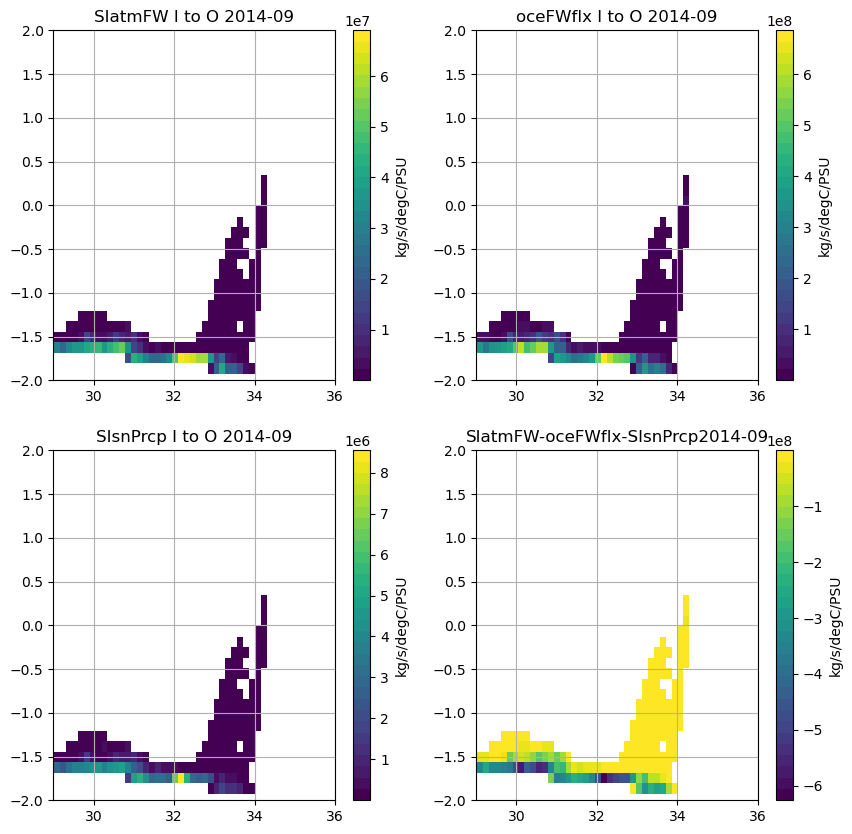

In [28]:
# make a 2 by 2 of each of the four terms to look at which is the biggest contribution and then total contribution

# try to plot an example
fig = plt.figure(figsize=(10,10))

# 
ax1 = plt.subplot(221)
AtoO_t1[AtoO_t1==0] = np.nan
cb1 = ax1.pcolormesh(Sbin, Tbin, mesh_SIatmFW_ItoO_t, cmap=cmap2)#,vmin=-7e-9,vmax=7e-9)
plt.colorbar(cb1, label="kg/s/degC/PSU")
ax1.set_title("SIatmFW I to O " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,2)
ax1.grid()

# 
ax1 = plt.subplot(222)
AtoO_t2[AtoO_t2==0] = np.nan
cb1 = ax1.pcolormesh(Sbin, Tbin, mesh_oceFWflx_ItoO_t, cmap=cmap2)#,vmin=0.1e-15,vmax=2.5e-8)
plt.colorbar(cb1, label="kg/s/degC/PSU")
ax1.set_title("oceFWflx I to O " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,2)
ax1.grid()


# 
ax1 = plt.subplot(223)
ItoO_t1[ItoO_t1==0] = np.nan
cb1 = ax1.pcolormesh(Sbin, Tbin, mesh_SIsnPrcp_t, cmap=cmap2)#,vmin=-3e-8,vmax=3e-8)
plt.colorbar(cb1, label="kg/s/degC/PSU")
ax1.set_title("SIsnPrcp I to O " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,2)
ax1.grid()

# 
ax1 = plt.subplot(224)
ItoO_t2[ItoO_t2==0] = np.nan
cb1 = ax1.pcolormesh(Sbin, Tbin, mesh_ItoO_t, cmap=cmap2)#,vmin=0.1e-15,vmax=2e-8)
plt.colorbar(cb1, label="kg/s/degC/PSU")
ax1.set_title("SIatmFW-oceFWflx-SIsnPrcp" + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,2)
ax1.grid()

plt.savefig(path + "negF_ItoO_September2014.png",dpi=300)

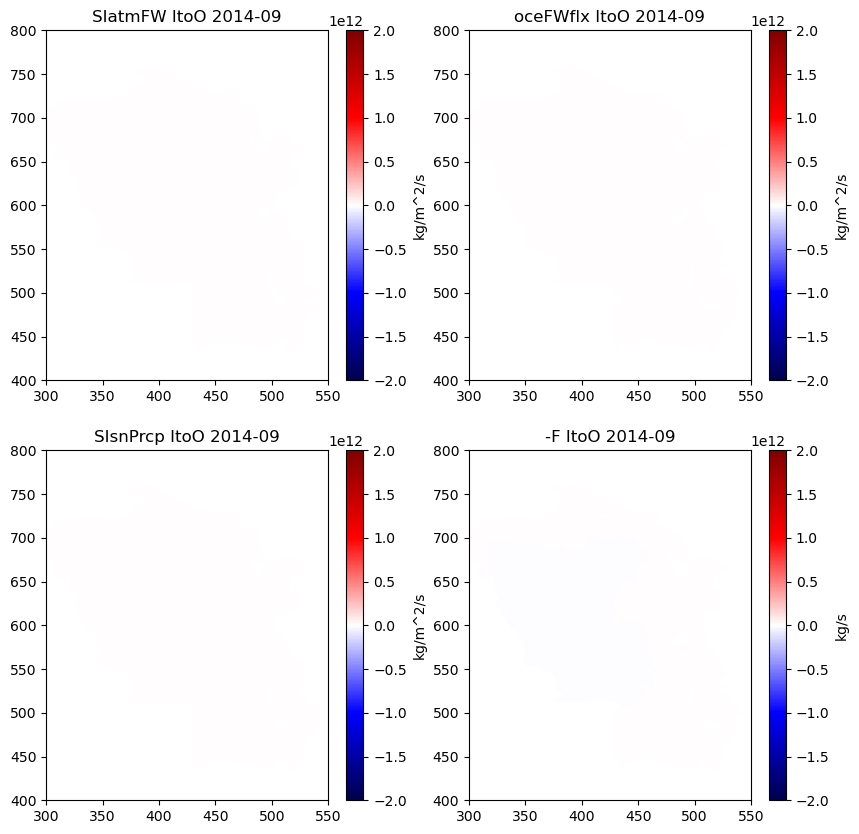

In [29]:
# look also in xyz space
# look at contribution from I to O for the two months and for A to O
fig = plt.figure(figsize=(10,10))

t = 1

# SIatmFW_ItoO - oceFWflx_ItoO - SIsnPrcp_ItoO

ax = plt.subplot(221)
cb = ax.pcolormesh(get_aste_tracer(SIatmFW_ItoO[t],nfx,nfy)[0],cmap='seismic',vmin=-2e12,vmax=2e12)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("SIatmFW ItoO " + datetimes[t].strftime("%Y-%m"))

ax = plt.subplot(222)
cb = ax.pcolormesh(get_aste_tracer(oceFWflx_ItoO[t],nfx,nfy)[0],cmap='seismic',vmin=-2e12,vmax=2e12)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("oceFWflx ItoO " + datetimes[t].strftime("%Y-%m"))

ax = plt.subplot(223)
cb = ax.pcolormesh(get_aste_tracer(SIsnPrcp_ItoO[t],nfx,nfy)[0],cmap='seismic',vmin=-2e12,vmax=2e12)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("SIsnPrcp ItoO " + datetimes[t].strftime("%Y-%m"))

ax = plt.subplot(224)
cb = ax.pcolormesh(get_aste_tracer((SIatmFW_ItoO[t] - oceFWflx_ItoO[t] - SIsnPrcp_ItoO[t]),nfx,nfy)[0],cmap='seismic',vmin=-2e12,vmax=2e12)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="kg/s")
ax.set_title("-F ItoO " + datetimes[t].strftime("%Y-%m"))

plt.savefig(path + "F_ItoO_xyzspace_m2.png",dpi=300)

# we can also do the forcing from atmosphere to ocean
SIatmFW-SIsnPrcp

In [21]:
SIatmFW_AtoO.shape
SIsnPrcp_AtoO.shape

(2, 1350, 270)

In [22]:
# create the mesh based on the subtraction
attr = SIatmFW_AtoO - SIsnPrcp_AtoO                  # kg/s
# only create the mesh with surface theta and salt
mesh_AtoO = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity[0], binned_theta[0],attr,idxs,dT,dS)   # kg/s/deg C/PSU

In [23]:
mesh_SIatmFW_AtoO = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity[0], binned_theta[0],SIatmFW_AtoO,idxs,dT,dS)   # kg/s/deg C/PSU
mesh_SIsnPrcp_AtoO = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity[0], binned_theta[0],SIsnPrcp_AtoO,idxs,dT,dS)   # kg/s/deg C/PSU

In [41]:
# make the four items for one month
t = 1

mesh_AtoO_t = np.nansum(mesh_AtoO[t],axis=2)   # kg/s/degC/PSU
mesh_SIatmFW_AtoO_t = np.nansum(mesh_SIatmFW_AtoO[t],axis=2)   # kg/s/degC/PSU
mesh_SIsnPrcp_AtoO_t = np.nansum(mesh_SIsnPrcp_AtoO[t],axis=2)   # kg/s/degC/PSU

# fillna
mesh_AtoO_t[mesh_AtoO_t == 0] = np.nan
mesh_SIatmFW_AtoO_t[mesh_SIatmFW_AtoO_t == 0] = np.nan
mesh_SIsnPrcp_AtoO_t[mesh_SIsnPrcp_AtoO_t ==0] = np.nan

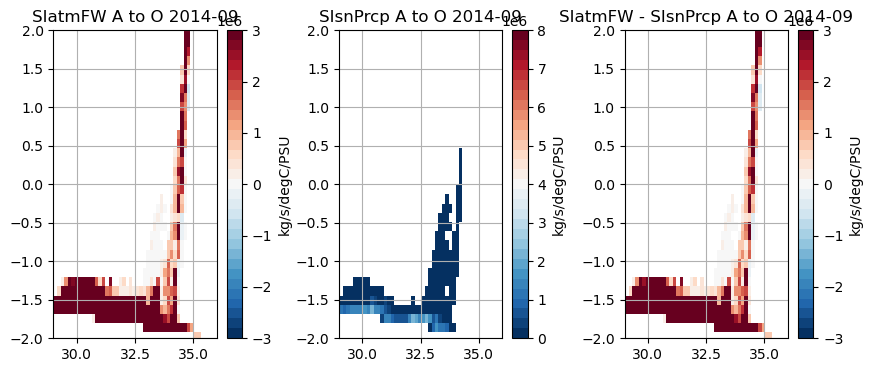

In [42]:
# make a 2 by 2 of each of the four terms to look at which is the biggest contribution and then total contribution

# try to plot an example
fig = plt.figure(figsize=(10,4))

# 
ax1 = plt.subplot(131)
cb1 = ax1.pcolormesh(Sbin, Tbin, mesh_SIatmFW_AtoO_t, cmap=cmap,vmin=-3e6,vmax=3e6)
plt.colorbar(cb1, label="kg/s/degC/PSU")
ax1.set_title("SIatmFW A to O " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,2)
ax1.grid()

# 
ax1 = plt.subplot(132)
cb1 = ax1.pcolormesh(Sbin, Tbin, mesh_SIsnPrcp_AtoO_t, cmap=cmap,vmin=0,vmax=8e6)
plt.colorbar(cb1, label="kg/s/degC/PSU")
ax1.set_title("SIsnPrcp A to O " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,2)
ax1.grid()


# 
ax1 = plt.subplot(133)
cb1 = ax1.pcolormesh(Sbin, Tbin, mesh_AtoO_t, cmap=cmap,vmin=-3e6,vmax=3e6)
plt.colorbar(cb1, label="kg/s/degC/PSU")
ax1.set_title("SIatmFW - SIsnPrcp A to O " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,2)
ax1.grid()

plt.subplots_adjust(wspace=0.4, hspace=0.4)


plt.savefig(path + "F_AtoO_Sept2014.png",dpi=300)

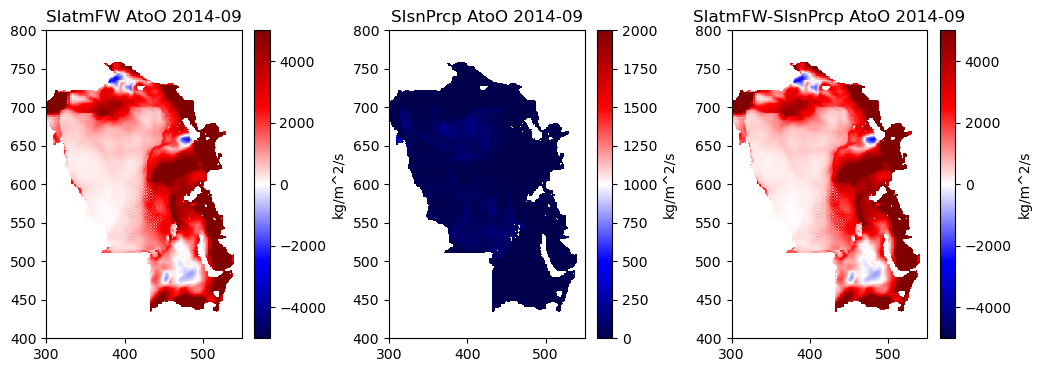

In [40]:
# plot in xyz space:
# look also in xyz space
# look at contribution from I to O for the two months and for A to O
fig = plt.figure(figsize=(12,4))

t = 1

# SIatmFW_ItoO - oceFWflx_ItoO - SIsnPrcp_ItoO

ax = plt.subplot(131)
cb = ax.pcolormesh(get_aste_tracer(SIatmFW_AtoO[t],nfx,nfy)[0],cmap='seismic',vmin=-5000,vmax=5000)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("SIatmFW AtoO " + datetimes[t].strftime("%Y-%m"))

ax = plt.subplot(132)
cb = ax.pcolormesh(get_aste_tracer(SIsnPrcp_AtoO[t],nfx,nfy)[0],cmap='seismic',vmin=0,vmax=2000)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("SIsnPrcp AtoO " + datetimes[t].strftime("%Y-%m"))

ax = plt.subplot(133)
cb = ax.pcolormesh(get_aste_tracer((SIatmFW_AtoO[t] - SIsnPrcp_AtoO[t]),nfx,nfy)[0],cmap='seismic',vmin=-5000,vmax=5000)
ax.set_xlim(300,550)
ax.set_ylim(400,800)
plt.colorbar(cb,label="kg/m^2/s")
ax.set_title("SIatmFW-SIsnPrcp AtoO " + datetimes[t].strftime("%Y-%m"))

plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.savefig(path + "F_AtoO_xyzspace_m2.png",dpi=300)